# Runs numerics for mean field model and numerics in finite state space continuous time Markov chain with N listings.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import csv
import time
import itertools
from numpy import random
from operator import itemgetter
import importlib
import multiprocessing as mp
import json

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
import experiment_helper
import exp_wrapper 

import finite_sim as sim
import finite_sim_wrapper as sim_wrapper

In [3]:
importlib.reload(exp_wrapper)
importlib.reload(experiment_helper)
importlib.reload(sim)
importlib.reload(sim_wrapper)

<module 'finite_sim_wrapper' from '/home/ralur/herding-bias/finite_sim_wrapper.py'>

# Setting parameters model parameters

In [4]:
alpha = 1
epsilon = 1
tau = 1
lams = [ .1, 1, 10]


tsr_ac_al_values = [.5]
cr_a_C = 0.5
lr_a_L = 0.5

tsr_est_types = ['tsr_est_naive', 'tsri_1.0','tsri_2.0'] + ['mrd_direct', 'mrd_spillover_seller', 'mrd_spillover_buyer', 'mrd_avg']


In [5]:
customer_types = ['c1']
listing_types = ['l']
exp_conditions = ['control', 'treat']
rhos_pre_treat = {'l':1} #adds up to 1
customer_proportions = {'c1':1} #adds up to 1

# used for multiplicative utilities
customer_type_base = {'c1':.315 }
listing_type_base = {'l':1}
exp_condition_base = {'control':1, 'treat':1.25}

vs = {}
#multiplicative -- default
for c in customer_types:
    vs[c] = {}
    vs[c]['treat'] = {}   
    vs[c]['control'] = {}
    for l in listing_types:
        for e in exp_conditions:
            vs[c][e][l] = round(customer_type_base[c]
                                *exp_condition_base[e]
                                *listing_type_base[l],4)

for c in customer_types:
    print("customer", c)
    print("control", vs[c]['control'])
    print("treatment", vs[c]['treat'], "\n")
print('Rhos:', rhos_pre_treat)
print("Customer Proportions:", customer_proportions)

customer c1
control {'l': 0.315}
treatment {'l': 0.3937} 

Rhos: {'l': 1}
Customer Proportions: {'c1': 1}


# Simulations

Setting simulation parameters. Remaining model parameters as defined in mean field parameters.

In [6]:
T_0 = 5
T_1 = 25

# normalizes time horizon by min(lam, tau)
T_start = {lam: T_0/min(lam,tau) for lam in lams}
T_end = {lam: T_1/min(lam,tau) for lam in lams}

varying_time_horizons = True

n_runs = 100
n_listings = 100

Define choice set type. If 'alpha', customers sample items into consideration set with prob alpha. If 'finite_k', each customer draws a fixed $k$ number of items into their consideration set.

In [7]:
choice_set_type = 'alpha' #customers sample items into consideration set with prob alpha
k = None

In [8]:
params = sim_wrapper.calc_all_params(listing_types, rhos_pre_treat, 
                                     customer_types, customer_proportions, vs, 
                                    alpha, epsilon, tau, lams,
                                    tsr_ac_al_values, cr_a_C, lr_a_L)

## Herding

In [9]:
events_herding = sim_wrapper.run_all_sims(n_runs, n_listings, T_start, T_end, 
                                  choice_set_type, k,
                                 alpha, epsilon, tau, lams,
                                 **params, herding=True)
est_stats_herding = sim_wrapper.calc_all_ests_stats("sample", T_start, T_end, 
                                            n_listings, tau=tau, 
                                            tsr_est_types=tsr_est_types,
                                            events=events_herding, 
                                            varying_time_horizons=varying_time_horizons,
                                            **params
                                           )

lambda= 0.1
Time elapsed:  27.36
lambda= 1
Time elapsed:  24.58
lambda= 10
Time elapsed:  122.06


In [10]:
est_stats_herding

est       gte      bias  bias_over_GTE  \
estimator_type       lambda                                                
cr                   0.1     0.041660  0.041596  0.000064       0.001541   
                     1.0     0.035950  0.031069  0.004881       0.157107   
                     10.0    0.152000  0.039333  0.112667       2.864467   
lr                   0.1     0.052100  0.041596  0.010504       0.252528   
                     1.0     0.034330  0.031069  0.003261       0.104965   
                     10.0    0.039240  0.039333 -0.000093      -0.002357   
tsr_est_naive        0.1     0.050078  0.041596  0.008482       0.203913   
                     1.0     0.044442  0.031069  0.013373       0.430420   
                     10.0    0.058276  0.039333  0.018943       0.481606   
tsri_1.0             0.1     0.053469  0.041596  0.011873       0.285432   
                     1.0     0.043809  0.031069  0.012740       0.410070   
                     10.0    0.058289  0.039333  0.018956       0.481938   
tsri_2.0             0.1     0.056634  0.041596  0.015038       0.361534   
                     1.0     0.043124  0.031069  0.012055       0.387999   
                     10.0    0.058322  0.039333  0.018989       0.482779   
mrd_direct           0.1     0.055311  0.041596  0.013715       0.329726   
                     1.0     0.044901  0.031069  0.013832       0.445214   
                     10.0   -0.822636  0.039333 -0.861969     -21.914801   
mrd_spillover_seller 0.1     0.047269  0.041596  0.005673       0.136382   
                     1.0     0.002568  0.031069 -0.028501      -0.917345   
                     10.0    0.880939  0.039333  0.841606      21.397091   
mrd_spillover_buyer  0.1    -0.010506  0.041596 -0.052102      -1.252572   
                     1.0    -0.005517  0.031069 -0.036586      -1.177564   
                     10.0   -0.152629  0.039333 -0.191962      -4.880459   
mrd_avg              0.1     0.092074  0.041596  0.050478       1.213535   
                     1.0     0.041952  0.031069  0.010884       0.350306   
                     10.0   -0.094326  0.039333 -0.133659      -3.398168   

                             abs_bias_over_GTE        std  std_over_GTE  \
estimator_type       lambda                                               
cr                   0.1              0.001541   0.022879      0.550025   
                     1.0              0.157107   0.020006      0.643916   
                     10.0             2.864467   0.035615      0.905471   
lr                   0.1              0.252528   0.022169      0.532950   
                     1.0              0.104965   0.017758      0.571558   
                     10.0             0.002357   0.032058      0.815040   
tsr_est_naive        0.1              0.203913   0.021740      0.522640   
                     1.0              0.430420   0.018242      0.587147   
                     10.0             0.481606   0.031046      0.789317   
tsri_1.0             0.1              0.285432   0.023092      0.555139   
                     1.0              0.410070   0.022478      0.723484   
                     10.0             0.481938   0.031019      0.788633   
tsri_2.0             0.1              0.361534   0.029638      0.712517   
                     1.0              0.387999   0.037638      1.211441   
                     10.0             0.482779   0.031011      0.788433   
mrd_direct           0.1              0.329726   0.091093      2.189946   
                     1.0              0.445214   0.052371      1.685641   
                     10.0            21.914801  10.808134    274.787308   
mrd_spillover_seller 0.1              0.136382   0.063112      1.517267   
                     1.0              0.917345   0.044757      1.440584   
                     10.0            21.397091  10.808717    274.802131   
mrd_spillover_buyer  0.1              1.252572   0.089988      2.163377   
                     1.0     

In [11]:
est_stats_herding = est_stats_herding.rename({'cr':"Customer-Side", 'lr':"Service-Side",
                            'tsri_2.0':'TSRI-2', 'tsri_1.0':'TSRI-1',
                             'tsr_est_naive':"TSR-Naive",
                            'mrd_direct':"MRD-Direct",
                            'mrd_spillover_seller':"MRD-Seller-Spillover",
                            'mrd_spillover_buyer':"MRD-Buyer-Spillover",
                            'mrd_avg':"MRD-Average"
                            })

## Competition

In [12]:
events_competition = sim_wrapper.run_all_sims(n_runs, n_listings, T_start, T_end, 
                                  choice_set_type, k,
                                 alpha, epsilon, tau, lams,
                                 **params, herding=False)
est_stats_competition = sim_wrapper.calc_all_ests_stats("sample", T_start, T_end, 
                                            n_listings, tau=tau, 
                                            tsr_est_types=tsr_est_types,
                                            events=events_competition, 
                                            varying_time_horizons=varying_time_horizons,
                                            **params
                                           )

lambda= 0.1
Time elapsed:  31.1
lambda= 1
Time elapsed:  27.89
lambda= 10
Time elapsed:  128.98


In [13]:
est_stats_competition = est_stats_competition.rename({'cr':"Customer-Side", 'lr':"Service-Side",
                            'tsri_2.0':'TSRI-2', 'tsri_1.0':'TSRI-1',
                             'tsr_est_naive':"TSR-Naive"
                            })

# Visualizations

## Visualizations: Herding

In [16]:
est_stats_herding = pd.read_csv("sampletotal_stats.csv", index_col=["estimator_type", "lambda"])

est_stats_herding = est_stats_herding.rename({'cr':"Customer-Side", 'lr':"Product-Side",
                            'tsri_2.0':'TSRI-2', 'tsri_1.0':'TSRI-1',
                            'tsr_est_naive':"TSR-Naive",
                            'mrd_direct':"MRD-Direct",
                            'mrd_spillover_seller':"MRD-Seller-Spillover",
                            'mrd_spillover_buyer':"MRD-Buyer-Spillover",
                            'mrd_avg':"MRD-Average"
                            })

In [ ]:
est_stats_herding

(<Figure size 1000x1000 with 6 Axes>,
 array([[<AxesSubplot:xlabel='Relative user arrival rate $\\lambda/\\tau$', ylabel='Bias'>,
         <AxesSubplot:xlabel='Relative user arrival rate $\\lambda/\\tau$', ylabel='Bias / GTE'>],
        [<AxesSubplot:xlabel='Relative user arrival rate $\\lambda/\\tau$', ylabel='SE'>,
         <AxesSubplot:xlabel='Relative user arrival rate $\\lambda/\\tau$', ylabel='SE / GTE'>],
        [<AxesSubplot:xlabel='Relative user arrival rate $\\lambda/\\tau$', ylabel='RMSE'>,
         <AxesSubplot:xlabel='Relative user arrival rate $\\lambda/\\tau$', ylabel='RMSE / GTE'>]],
       dtype=object))

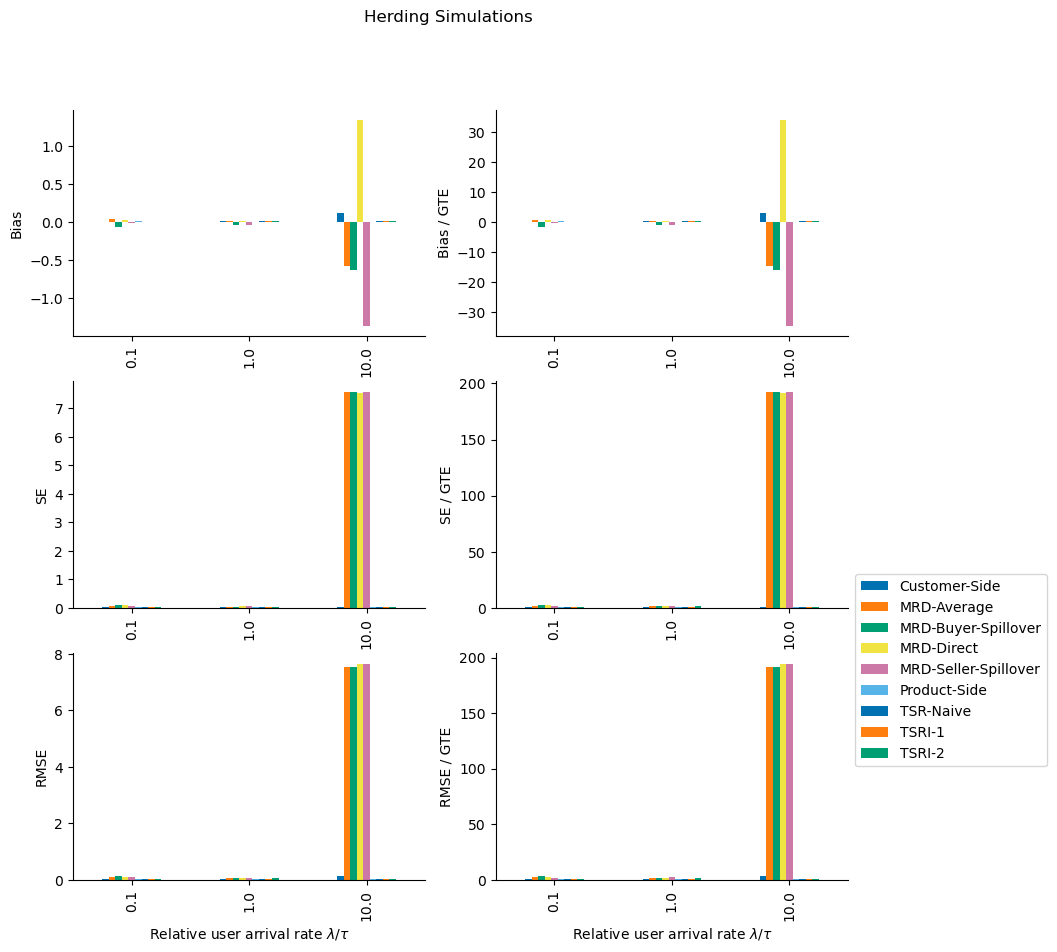

In [23]:
sim_wrapper.plot_all_stats(est_stats_herding, "Herding Simulations")

## Visualizations: competition

In [18]:
est_stats_competition = pd.read_csv("sample_total_stats_competition.csv", index_col=["estimator_type", "lambda"])

est_stats_competition = est_stats_competition.rename({'cr':"Customer-Side", 'lr':"Service-Side",
                            'tsri_2.0':'TSRI-2', 'tsri_1.0':'TSRI-1',
                             'tsr_est_naive':"TSR-Naive"
                            })

FileNotFoundError: [Errno 2] No such file or directory: 'sample_total_stats_competition.csv'

In [ ]:
sim_wrapper.plot_all_stats(est_stats_competition, "Crowding Out Simulations")

## Visualizations: Herding, no recency

In [19]:
est_stats_herding_no_recency = pd.read_csv("sample_total_stats_herding_no_recency.csv", index_col=["estimator_type", "lambda"])

est_stats_herding_no_recency = est_stats_herding_no_recency.rename({'cr':"Customer-Side", 'lr':"Service-Side",
                            'tsri_2.0':'TSRI-2', 'tsri_1.0':'TSRI-1',
                             'tsr_est_naive':"TSR-Naive"
                            })

FileNotFoundError: [Errno 2] No such file or directory: 'sample_total_stats_herding_no_recency.csv'

(<Figure size 720x720 with 6 Axes>,
 array([[<AxesSubplot:xlabel='Relative user arrival rate $\\lambda/\\tau$', ylabel='Bias'>,
         <AxesSubplot:xlabel='Relative user arrival rate $\\lambda/\\tau$', ylabel='Bias / GTE'>],
        [<AxesSubplot:xlabel='Relative user arrival rate $\\lambda/\\tau$', ylabel='SE'>,
         <AxesSubplot:xlabel='Relative user arrival rate $\\lambda/\\tau$', ylabel='SE / GTE'>],
        [<AxesSubplot:xlabel='Relative user arrival rate $\\lambda/\\tau$', ylabel='RMSE'>,
         <AxesSubplot:xlabel='Relative user arrival rate $\\lambda/\\tau$', ylabel='RMSE / GTE'>]],
       dtype=object))

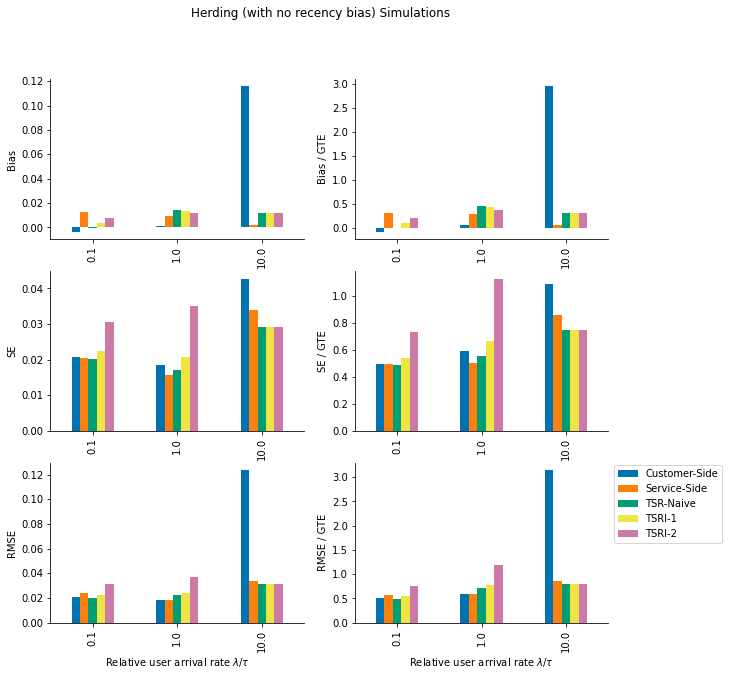

In [13]:
sim_wrapper.plot_all_stats(est_stats_herding_no_recency, "Herding (with no recency bias) Simulations")